In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import numpy as np
import random

## Creating Simple random Graph for problem:

In [13]:
# G = nx.erdos_renyi_graph(np.random.randint(3, 30), 0.5, directed=False)
G = nx.erdos_renyi_graph(6, 0.5, directed=False)

In [14]:
print('Nodes:', G.nodes)
print('Edges:', G.edges)

Nodes: [0, 1, 2, 3, 4, 5]
Edges: [(0, 3), (0, 4), (1, 4), (1, 5), (2, 4), (2, 5)]


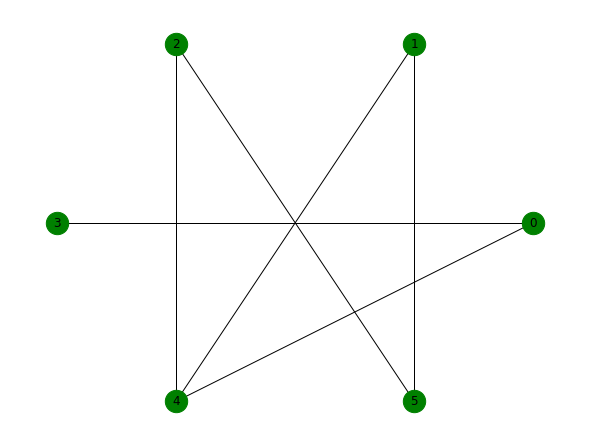

In [15]:
position = nx.circular_layout(G)
plt.figure(figsize=(8,6))
nx.draw(G,pos=position ,node_color='green', 
        with_labels=True, 
        node_size=500)

## Applaying greedy algorithm for finding solution:

In [16]:
def find_Vertex_cover_greedy(graph):
    visited = [0 for i in range(len(graph))]
    cover_count = 0
    for edge in graph.edges:  # traverse edges
        u, v = edge
        print('processing edge ({} -> {})'.format(u, v))
        if ((visited[u] == 0) and (visited[v] == 0)):
            visited[v], visited[u] = 1, 1
            cover_count+=2

    return [node for node in range(len(visited)) if visited[node]]

In [17]:
cover_nodes = find_Vertex_cover_greedy(G)
print("\ncalculated vertex_cover: ", len(cover_nodes))

processing edge (0 -> 3)
processing edge (0 -> 4)
processing edge (1 -> 4)
processing edge (1 -> 5)
processing edge (2 -> 4)
processing edge (2 -> 5)

calculated vertex_cover:  6


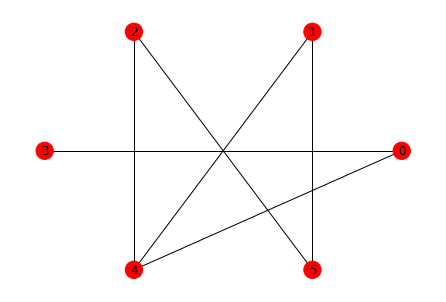

In [18]:
colors = []
for node in G.nodes:
    if node in cover_nodes:
        colors.append('red')
    else:
        colors.append('green')

nx.draw_circular(G, node_color=colors, with_labels=True)

## Using genetic algorithm for solving this problem:

we use binary representation for this problem. 

In [19]:
class EA:
    def __init__(self, graph, itrs, chromosome_len, population_size, population_initial, vertices, crossover_prob=0.5, mutat_prob=0.05) -> None:
        self.graph = graph
        self.itrs = itrs
        self.chromosome_len = chromosome_len
        self.population_size = population_size
        self.population_initial = population_initial
        self.vertices = vertices   # number of vertices that we want to solve this problem with it.
        self.crossover_prob = crossover_prob
        self.mutat_prob = mutat_prob
        
    def generate_population(self):
        population = []
        for i in range(self.population_initial):
            chromosome, samples = np.zeros(self.chromosome_len, dtype= int), random.sample(range(0, self.chromosome_len), k = self.vertices)

            for j in range(self.vertices):
                chromosome[samples[j]] = 1   # randomly initilize a gene (in current chromosome) with '1' 
            population.append(chromosome)
        return population

    def fitness_func(self, chromosome):  # calculates cost for given chromosome
        cost = 0   # penalty for current chromosome
        for edge in self.graph.edges:
            u,v = edge
            if ((chromosome[u] == 0) and (chromosome[v] == 0)):
                cost += 1
        return cost   # cost calculated for this chromosome.

    def selection(self, population):
        score = []
        new_population = []
        crossover_prob = random.random()

        for i in range(len(population)):
            score.append(self.fitness_func(population[i]))
        sorted_index = np.argsort(score)  # sort and return indexes...

        for i in range(len(population)):
            new_population.append(population[sorted_index[i]])

            if((i+1) == self.population_size):
                break
        # population = new_population 
        
        return new_population, score[sorted_index[0]]

    def crossover(self, population):

        new_population = []
      
        for individual in population:

            # First solution
            offspring = individual.copy()
            # Second solution
            mate_with = population[int(random.uniform(0, len(population) ))]   # select one of the chromosome in the population for mating
            
            offspring_unique = []
            mate_with_unique = []
            
            # Store all vertices of Solution-1 and Solution-2
            for j in range(self.chromosome_len):
                if(offspring[j] == 1):
                    offspring_unique.append(j)
                if(mate_with[j] == 1):
                    mate_with_unique.append(j)

            offspring_unique = np.setdiff1d(offspring, mate_with)
            mate_with_unique = np.setdiff1d(mate_with, offspring)
            random.shuffle(offspring_unique)
            random.shuffle(mate_with_unique)

            min_len = min(len(offspring_unique), len(mate_with_unique))
            swap = math.ceil(self.crossover_prob * min_len)

            for j in range(swap):  # updating chromosome's genes
                offspring[mate_with_unique[j]] = 1
                offspring[offspring_unique[j]] = 0
            
            new_population.append(offspring)

        return new_population

    def mutate_chromosome(self, chromosome):

        zeroes = []
        ones = []

        for j in range(self.chromosome_len):
            if chromosome[j] == 1:
                ones.append(j)
            else:
                zeroes.append(j)

        # suffle ones indices and zeros indeces
        random.shuffle(ones)
        random.shuffle(zeroes)

        coin_toss = random.random()

        if(coin_toss <= 0.5):
             # method number 1
            swaps = min(len(ones),len(zeroes))

            for i in range(swaps):  # iterate through minimum len of one indices and zero indices.
                coin_toss2 = random.random()

                if(coin_toss2 < self.mutat_prob):
                    chromosome[ones[i]] = 0
                    chromosome[zeroes[i]] = 1

                    temp = ones[i]
                    ones[i] = zeroes[i]
                    zeroes[i] = temp
        else:    
            # method number 2
            mutate_lst = []
            for edge in self.graph.edges:
                u,v = edge

                if((chromosome[u] == 0) and (chromosome[v] == 0)):
                    coin_toss2 = random.random()

                    if(coin_toss2 < self.mutat_prob):
                        coin_toss3 = random.random()

                        if(coin_toss3 <= 0.5):
                            if(u not in mutate_lst):
                                mutate_lst.append(u)
                        else:
                            if(v not in mutate_lst):
                                mutate_lst.append(v)

            random.shuffle(mutate_lst)
            sz = min(len(ones),len(mutate_lst))
            
            for j in range(sz):
                chromosome[ones[j]] = 0
                chromosome[mutate_lst[j]] = 1
                #Swapping logic
                dummy = ones[j]
                ones[j] = mutate_lst[j]
                mutate_lst[j] = dummy
            
        return chromosome

    def genetic_algorithm(self, log):
        population = self.generate_population()

        for generation in range(self.itrs):

            population = self.crossover(population)  # cross over
            mutated_population = []

            for chromosome in population:  # mutate some of individuals...
                mutated_population.append( self.mutate_chromosome(chromosome))

            population = mutated_population
            population, fitness_score = self.selection(population)
            if ((generation % 2) == 0) and log:
                print("\n--->> k: {}, generation: {}, fitness_score: {}".format(self.vertices, generation, fitness_score))
            if fitness_score == 0:
                break

        result = []
        best_individual = population[0]
        
        for index, gene in enumerate(best_individual):
            if(gene == 1):
                result.append(index)
        print("\n---->>> k:{}, generation: {}, fitness_score: {}, best_individual: {}".format(self.vertices, generation, fitness_score, result))
        return fitness_score, result

    

In [20]:
ea = EA(G, 450, 250, 1500, 1000, 3)
fitness, solution_nodes = ea.genetic_algorithm(log=True)


--->> k: 3, generation: 0, fitness_score: 1

--->> k: 3, generation: 2, fitness_score: 0

---->>> k:3, generation: 2, fitness_score: 0, best_individual: [0, 4, 5]


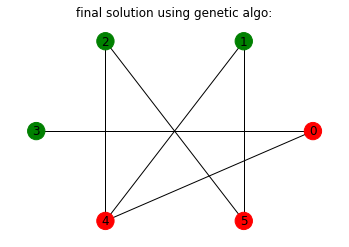

In [21]:
colors = []
for node in G.nodes:
    if node in solution_nodes:
        colors.append('red')   # red nodes are coverd vertices...
    else:
        colors.append('green')

plt.title('final solution using genetic algo:')
nx.draw_circular(G, node_color=colors, with_labels=True)

## applying on full random generated graph:

In [37]:
G2 = nx.erdos_renyi_graph(np.random.randint(3, 100), 0.5, directed=False)

In [38]:
print('Nodes:', G2.nodes)
print('Edges:', G2.edges)

Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Edges: [(0, 2), (0, 3), (0, 4), (0, 11), (0, 13), (0, 14), (1, 2), (1, 4), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 14), (1, 15), (1, 16), (2, 3), (2, 5), (2, 8), (2, 9), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (3, 4), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 14), (3, 16), (4, 6), (4, 10), (4, 12), (4, 16), (5, 6), (5, 7), (5, 9), (5, 10), (5, 14), (6, 7), (6, 10), (6, 12), (6, 14), (6, 15), (6, 16), (7, 12), (7, 14), (7, 15), (8, 9), (8, 10), (8, 11), (8, 13), (8, 14), (8, 16), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (9, 16), (10, 11), (10, 12), (10, 13), (10, 14), (10, 15), (10, 16), (11, 12), (11, 15), (12, 13), (12, 14), (13, 14), (14, 15), (14, 16), (15, 16)]


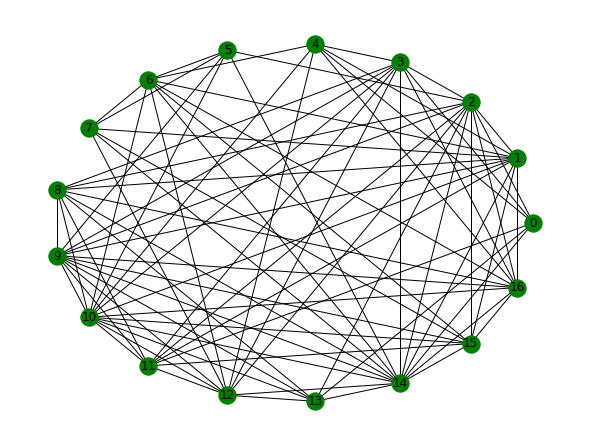

In [39]:
position = nx.circular_layout(G2)
plt.figure(figsize=(8,6))
nx.draw(G2,pos=position ,node_color='green', 
        with_labels=True, 
        node_size=300)

In [40]:
cover_nodes = find_Vertex_cover_greedy(G2)
print("\ncalculated vertex_cover: ", len(cover_nodes))

processing edge (0 -> 2)
processing edge (0 -> 3)
processing edge (0 -> 4)
processing edge (0 -> 11)
processing edge (0 -> 13)
processing edge (0 -> 14)
processing edge (1 -> 2)
processing edge (1 -> 4)
processing edge (1 -> 6)
processing edge (1 -> 7)
processing edge (1 -> 8)
processing edge (1 -> 9)
processing edge (1 -> 10)
processing edge (1 -> 11)
processing edge (1 -> 14)
processing edge (1 -> 15)
processing edge (1 -> 16)
processing edge (2 -> 3)
processing edge (2 -> 5)
processing edge (2 -> 8)
processing edge (2 -> 9)
processing edge (2 -> 11)
processing edge (2 -> 12)
processing edge (2 -> 13)
processing edge (2 -> 14)
processing edge (2 -> 15)
processing edge (2 -> 16)
processing edge (3 -> 4)
processing edge (3 -> 8)
processing edge (3 -> 9)
processing edge (3 -> 10)
processing edge (3 -> 11)
processing edge (3 -> 12)
processing edge (3 -> 14)
processing edge (3 -> 16)
processing edge (4 -> 6)
processing edge (4 -> 10)
processing edge (4 -> 12)
processing edge (4 -> 16)
pro

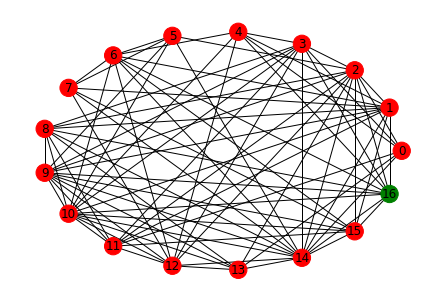

In [41]:
colors = []
for node in G2.nodes:
    if node in cover_nodes:
        colors.append('red')
    else:
        colors.append('green')

nx.draw_circular(G2, node_color=colors, with_labels=True)

In [42]:

def findminVertexCover(chromosome_size, crossover_prob, mutat_prob, pop_init, pop_total, itrs, graph, start, end, log):
    result_dict = {}
    l = start
    h = end

    while(l <= h):

        m = int( (l + h) / 2)
        ea = EA(graph=graph ,itrs=itrs, chromosome_len=chromosome_size, population_size=pop_total, 
                population_initial=pop_init, vertices=m, mutat_prob=mutat_prob, crossover_prob=crossover_prob)
        
        fitness_val, result = ea.genetic_algorithm(log=log)

        if ea:
            del ea
        print('---------------------------------------------------------------\n')
        if fitness_val == 0:
            result_dict[m] = result
            h = m - 1
        else:
            l = m + 1
    return result_dict
    
    

In [43]:
best_sol = findminVertexCover(250, 0.5, 0.05, 1000, 1500, 450, G2, (len(cover_nodes) / 2), 250, True)


--->> k: 129, generation: 0, fitness_score: 0

---->>> k:129, generation: 0, fitness_score: 0, best_individual: [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 21, 23, 24, 25, 26, 27, 28, 29, 32, 34, 35, 37, 39, 43, 46, 49, 50, 53, 56, 57, 58, 60, 63, 64, 66, 69, 70, 72, 73, 74, 75, 78, 80, 81, 84, 86, 88, 89, 91, 92, 98, 101, 106, 107, 109, 110, 112, 113, 115, 116, 118, 120, 121, 124, 125, 126, 131, 135, 138, 141, 142, 145, 146, 148, 149, 152, 153, 155, 156, 157, 158, 159, 163, 165, 167, 174, 175, 176, 178, 179, 180, 184, 188, 190, 192, 197, 199, 201, 202, 204, 208, 209, 213, 216, 219, 221, 223, 224, 226, 227, 228, 229, 230, 231, 232, 234, 235, 236, 239, 241, 242, 246, 248]
---------------------------------------------------------------


--->> k: 68, generation: 0, fitness_score: 3

--->> k: 68, generation: 2, fitness_score: 3

--->> k: 68, generation: 4, fitness_score: 1

--->> k: 68, generation: 6, fitness_score: 1

---->>> k:68, generation: 7, fitness_score: 0, best_indi

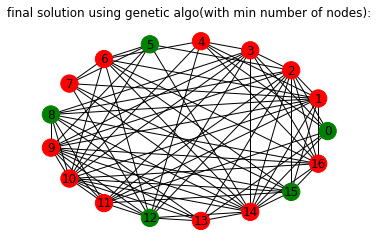

In [50]:
colors = []
for node in G2.nodes:
    if node in best_sol[min(best_sol.keys())]:
        colors.append('red')
    else:
        colors.append('green')
        
plt.title('final solution using genetic algo(with min number of nodes):')
nx.draw_circular(G2, node_color=colors, with_labels=True)